In [1]:
import json 
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler, PowerTransformer
from sklearn.manifold import TSNE
import plotly.express as px
from sklearn.decomposition import PCA

import seaborn as sns


## Mixture Models
references: https://www.cs.toronto.edu/~rgrosse/csc321/mixture_models.pdf 

https://www.kaggle.com/code/minc33/visualizing-high-dimensional-clusters

In [2]:


df = pd.read_csv('data/data_merged_encoded.csv')

# Select numeric columns for the mixture model
numeric_columns = df.select_dtypes(include=['float64', 'int64']).columns.drop('FIPS')
X = df[numeric_columns].dropna()  

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


In [ ]:
correlation_matrix = df[numeric_columns].corr()

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Feature Correlation Matrix")
#plt.xticks(rotation=45)  
plt.show()


### normalize data 

Cluster Shape Assumption:

Gaussian Mixture Models assume clusters are normally distributed

Violation Check: Use Q-Q plots or Shapiro-Wilk test on cluster subsets


In [ ]:
# import scipy.stats as stats


# for feature in ["Percent of adults who are not high school graduates, 2019-23"]:
#     # Q-Q Plot
#     plt.figure(figsize=(6, 4))
#     stats.probplot(cluster_data[feature].dropna(), dist="norm", plot=plt)
#     plt.title(f"Q-Q Plot for {feature} in Cluster {cluster}")
#     plt.show()
    
#     # Shapiro-Wilk Test
#     stat, p_value = stats.shapiro(cluster_data[feature].dropna())
#     print(f"Shapiro-Wilk Test for {feature}: W={stat:.4f}, p={p_value:.4f}")
#     if p_value > 0.05:
#         print(f"{feature} appears to be normally distributed (p > 0.05).")
#     else:
#         print(f"{feature} does NOT appear to be normally distributed (p <= 0.05).")

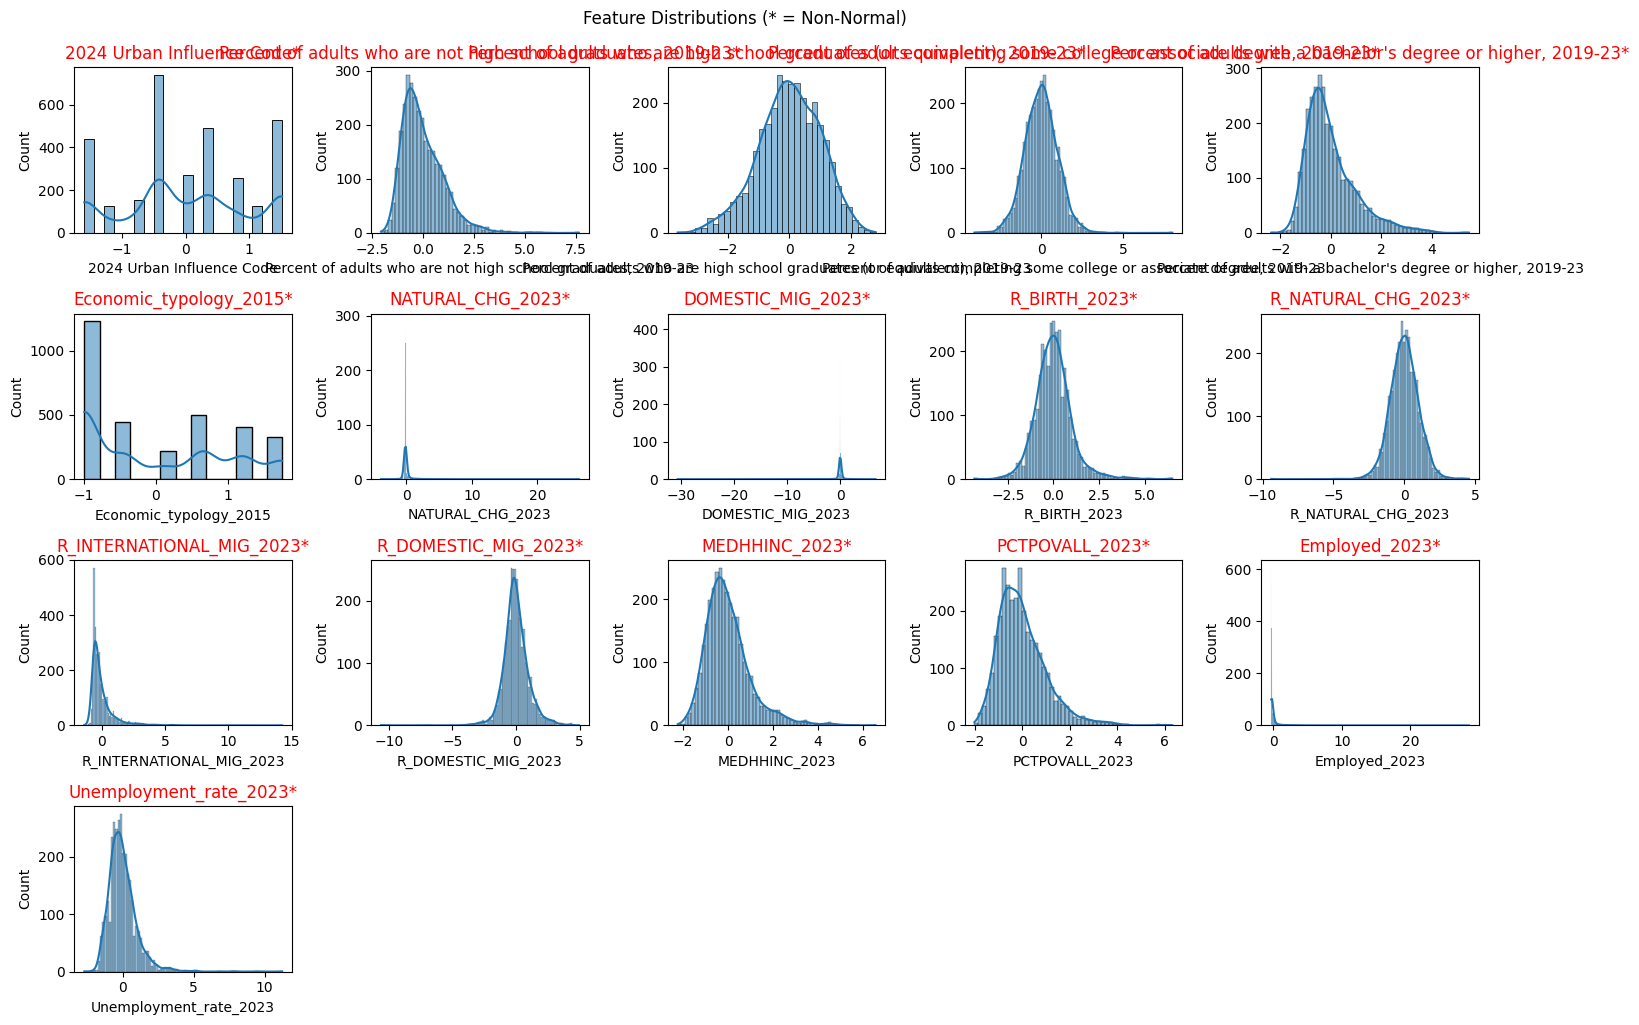

Non-normal features (16):
 ['2024 Urban Influence Code', 'Percent of adults who are not high school graduates, 2019-23', 'Percent of adults who are high school graduates (or equivalent), 2019-23', 'Percent of adults completing some college or associate degree, 2019-23', "Percent of adults with a bachelor's degree or higher, 2019-23", 'Economic_typology_2015', 'NATURAL_CHG_2023', 'DOMESTIC_MIG_2023', 'R_BIRTH_2023', 'R_NATURAL_CHG_2023', 'R_INTERNATIONAL_MIG_2023', 'R_DOMESTIC_MIG_2023', 'MEDHHINC_2023', 'PCTPOVALL_2023', 'Employed_2023', 'Unemployment_rate_2023']


In [4]:
import numpy as np
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt

# Select numeric features (excluding FIPS and cluster labels)
numeric_cols = df.select_dtypes(include=['number']).columns
features = [col for col in numeric_cols if col not in ['FIPS', 'cluster']]

# Shapiro-Wilk test for normality (p-value < 0.05 indicates non-normal)
non_normal_features = []
plt.figure(figsize=(15, 10))

for i, feature in enumerate(features, 1):
    plt.subplot(4, 5, i)
    sns.histplot(df[feature], kde=True)
    plt.title(feature)
    
    # Normality test (sample < 5000 for Shapiro-Wilk)
    stat, p = stats.shapiro(df[feature].sample(min(5000, len(df)))) if len(df) > 3 else (0, 1)
    if p < 0.05:
        non_normal_features.append(feature)
        plt.gca().set_title(f"{feature}*", color='red')

plt.tight_layout()
plt.suptitle("Feature Distributions (* = Non-Normal)", y=1.02)
plt.show()

print(f"Non-normal features ({len(non_normal_features)}):\n", non_normal_features)

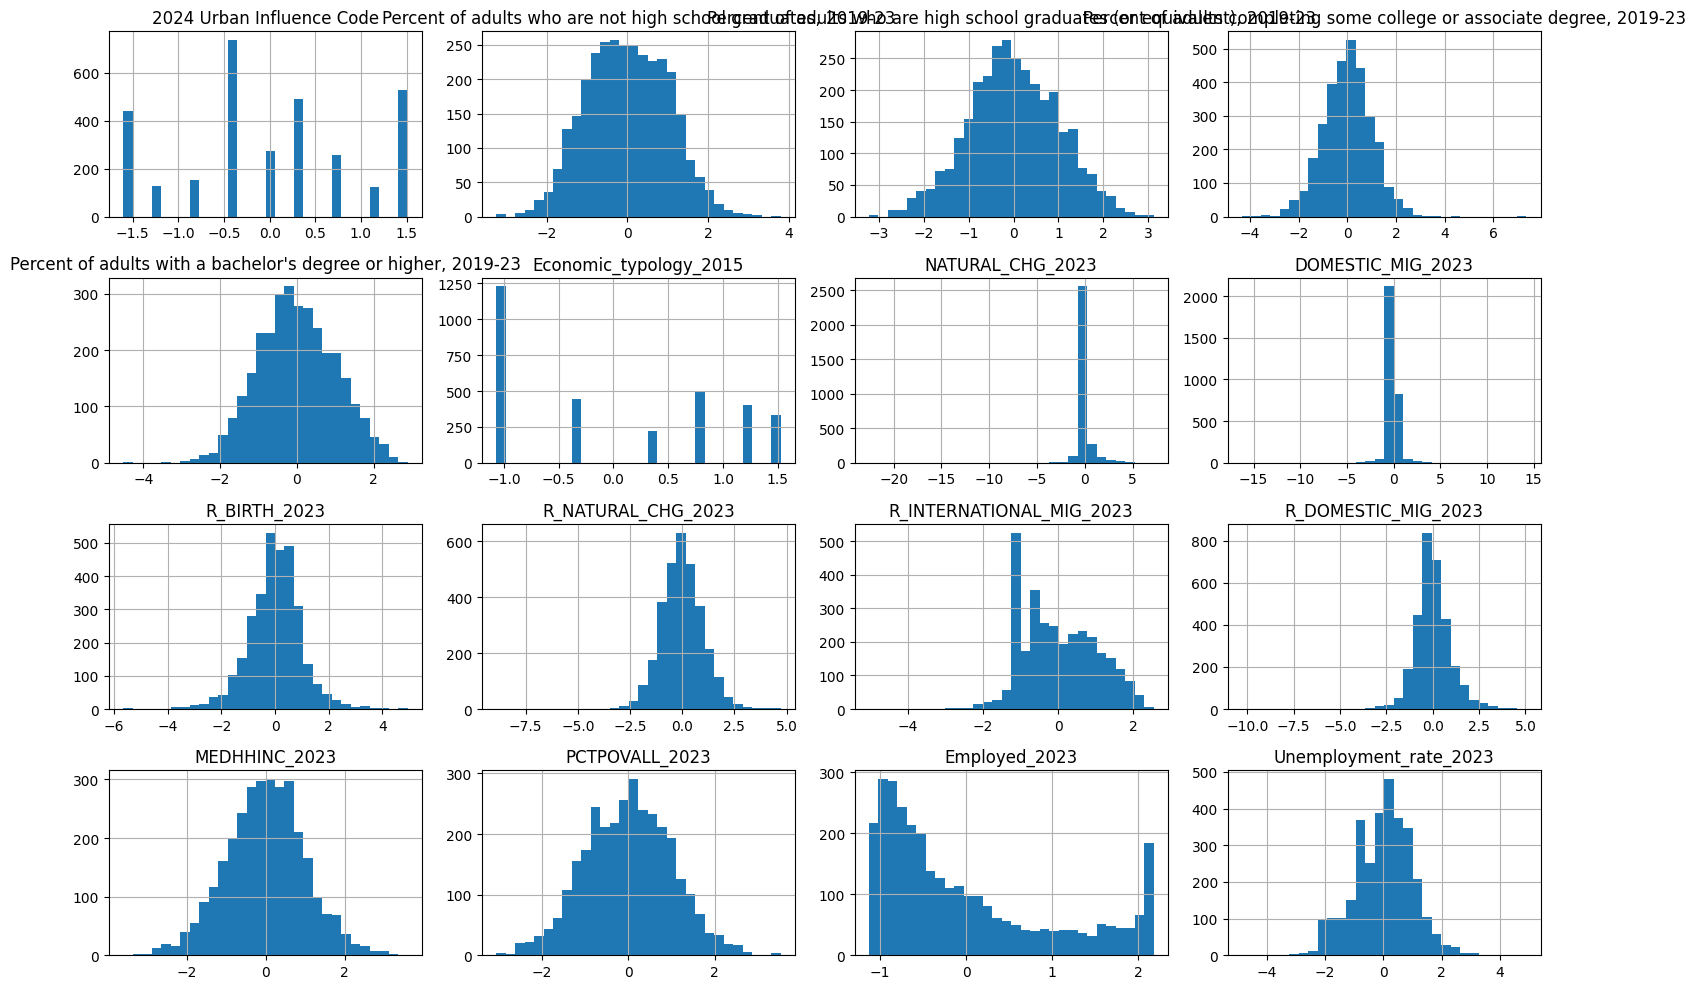

In [5]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

# Define preprocessing
normalize_transformer = Pipeline([
    ('yeojohnson', PowerTransformer(method='yeo-johnson'))
])

preprocessor = ColumnTransformer([
    ('normalize', normalize_transformer, non_normal_features),
    ('passthrough', 'passthrough', [f for f in features if f not in non_normal_features])
])

# Apply to data
X_normalized = preprocessor.fit_transform(df[features])
normalized_df = pd.DataFrame(X_normalized, 
                            columns=non_normal_features + [f for f in features if f not in non_normal_features])

# Verify final distributions
normalized_df.hist(figsize=(15, 10), bins=30)
plt.tight_layout()
plt.show()


In [6]:
normalized_df['FIPS'] = df['FIPS'].values
normalized_df.head()
df = normalized_df

Text(0, 0.5, 'BIC Score')

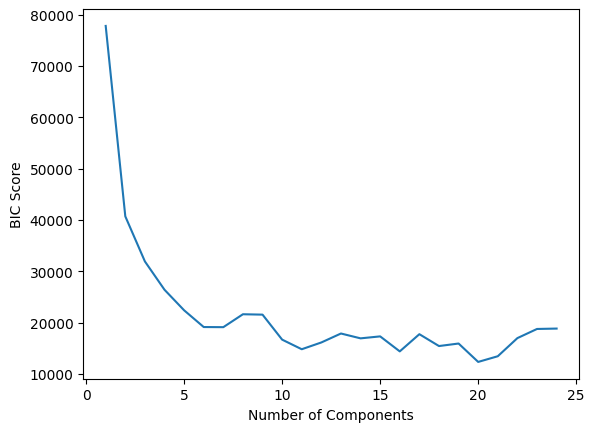

In [7]:
n_components_range = range(1, 25)
bics = []
for n in n_components_range:
    gmm = GaussianMixture(n_components=n, random_state=42)
    gmm.fit(X_scaled)
    bics.append(gmm.bic(X_scaled))

plt.plot(n_components_range, bics)
plt.xlabel('Number of Components')
plt.ylabel('BIC Score')


In [ ]:
print(min(bics), bics.index(min(bics)))

In [8]:
best_n_components = 16  # Example from BIC analysis
gmm = GaussianMixture(n_components=best_n_components, covariance_type='full', random_state=42)
gmm.fit(X_scaled)
cluster_labels = gmm.predict(X_scaled)

In [ ]:
tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(X_scaled)
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=cluster_labels, cmap='viridis')

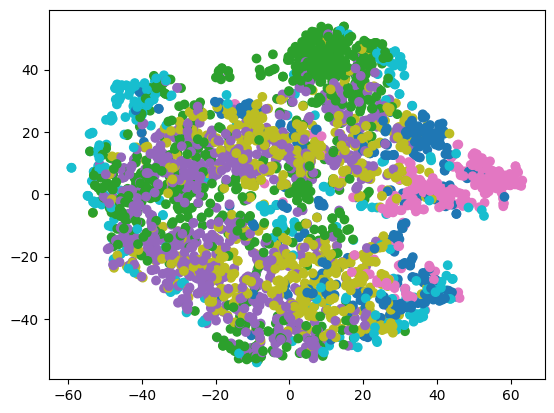

In [8]:
best_n_components = 6
gmm = GaussianMixture(n_components=best_n_components, covariance_type='full', random_state=42)
gmm.fit(X_scaled)
cluster_labels = gmm.predict(X_scaled)
tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(X_scaled)
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=cluster_labels, cmap='tab10')

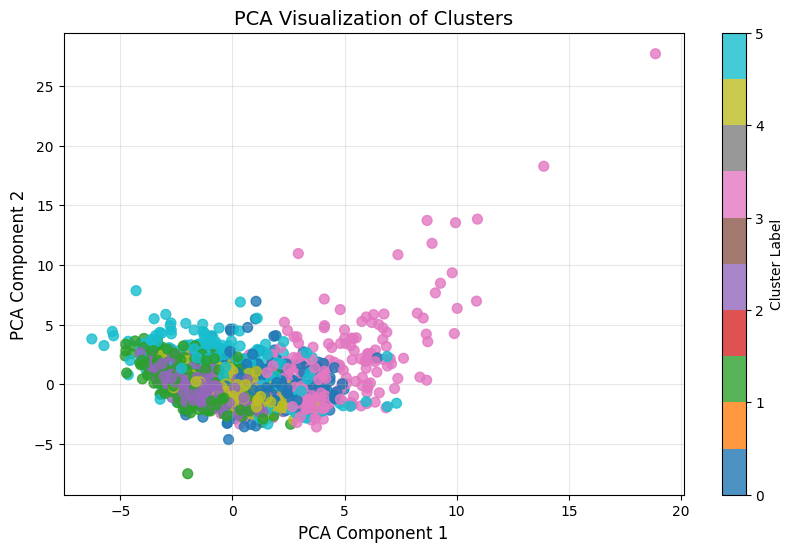

In [9]:
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_scaled)

# Scatter plot with PCA components
plt.figure(figsize=(10, 6))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=cluster_labels, cmap='tab10', s=50, alpha=0.8)
plt.colorbar(scatter, label='Cluster Label')
plt.title('PCA Visualization of Clusters', fontsize=14)
plt.xlabel('PCA Component 1', fontsize=12)
plt.ylabel('PCA Component 2', fontsize=12)
plt.grid(alpha=0.3)
plt.show()

In [10]:
fips_mapping = pd.read_csv('data/FipsCountyCodes.csv')
df['FIPS'] = df['FIPS'].astype(str)
fips_mapping['FIPS'] = fips_mapping['FIPS'].astype(str)
df = df.merge(fips_mapping[['FIPS', 'Name']], left_on='FIPS', right_on='FIPS', how='left')


In [11]:
df['cluster'] = cluster_labels
df.head()

,2024 Urban Influence Code,"Percent of adults who are not high school graduates, 2019-23","Percent of adults who are high school graduates (or equivalent), 2019-23","Percent of adults completing some college or associate degree, 2019-23","Percent of adults with a bachelor's degree or higher, 2019-23",Economic_typology_2015,NATURAL_CHG_2023,DOMESTIC_MIG_2023,R_BIRTH_2023,R_NATURAL_CHG_2023,R_INTERNATIONAL_MIG_2023,R_DOMESTIC_MIG_2023,MEDHHINC_2023,PCTPOVALL_2023,Employed_2023,Unemployment_rate_2023,FIPS,Name,cluster
0,-0.422178,-0.106369,-0.202628,-0.278921,0.676592,-1.072361,0.137978,0.092979,0.548017,0.778317,-0.165991,0.354773,0.418895,-0.418023,0.392220,-1.470967,1001,"AL, Autauga",4
1,-0.422178,-0.465935,-0.839387,0.117663,1.018857,1.526775,-0.214712,2.729940,-0.177846,0.364750,0.456047,1.883474,0.715614,-0.864977,1.790682,-1.325472,1003,"AL, Baldwin",0
2,-0.031247,1.691373,0.459182,-0.390700,-1.733247,0.791582,-0.166668,-0.087875,0.117921,-0.279212,-0.294670,-0.438192,-1.569151,1.693392,-0.601697,0.839202,1005,"AL, Barbour",2
3,-1.604484,1.428454,0.960501,-0.585835,-1.732531,-1.072361,-0.106815,-0.095770,0.158644,-0.044581,-1.056185,-0.540558,-0.521844,0.985654,-0.539747,-1.045191,1007,"AL, Bibb",2
4,-1.604484,1.154153,0.185939,0.138068,-0.948842,-1.072361,-0.157518,0.047308,0.472439,0.170248,-0.430986,0.179411,0.172622,-0.155718,0.344243,-1.619961,1009,"AL, Blount",4


In [12]:
from sklearn.feature_selection import f_classif

# Perform ANOVA between clusters
f_scores, p_values = f_classif(X, df['cluster'])

feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'F-Score': f_scores,
    'P-Value': p_values
}).sort_values('F-Score', ascending=False)

print("\nTop Influential Features:")
print(feature_importance.head(10))


Top Influential Features:
                                              Feature     F-Score  \
0                           2024 Urban Influence Code  581.959078   
4   Percent of adults with a bachelor's degree or ...  387.164019   
12                                      MEDHHINC_2023  338.413351   
2   Percent of adults who are high school graduate...  311.276072   
14                                      Employed_2023  274.876446   
10                           R_INTERNATIONAL_MIG_2023  237.465865   
9                                  R_NATURAL_CHG_2023  231.349257   
6                                    NATURAL_CHG_2023  147.160146   
13                                     PCTPOVALL_2023   75.134395   
1   Percent of adults who are not high school grad...   59.621844   

          P-Value  
0    0.000000e+00  
4   9.881313e-324  
12  2.110904e-290  
2   4.780389e-271  
14  3.427747e-244  
10  1.923982e-215  
9   1.264618e-210  
6   1.272802e-140  
13   1.521616e-74  
1    1.785573

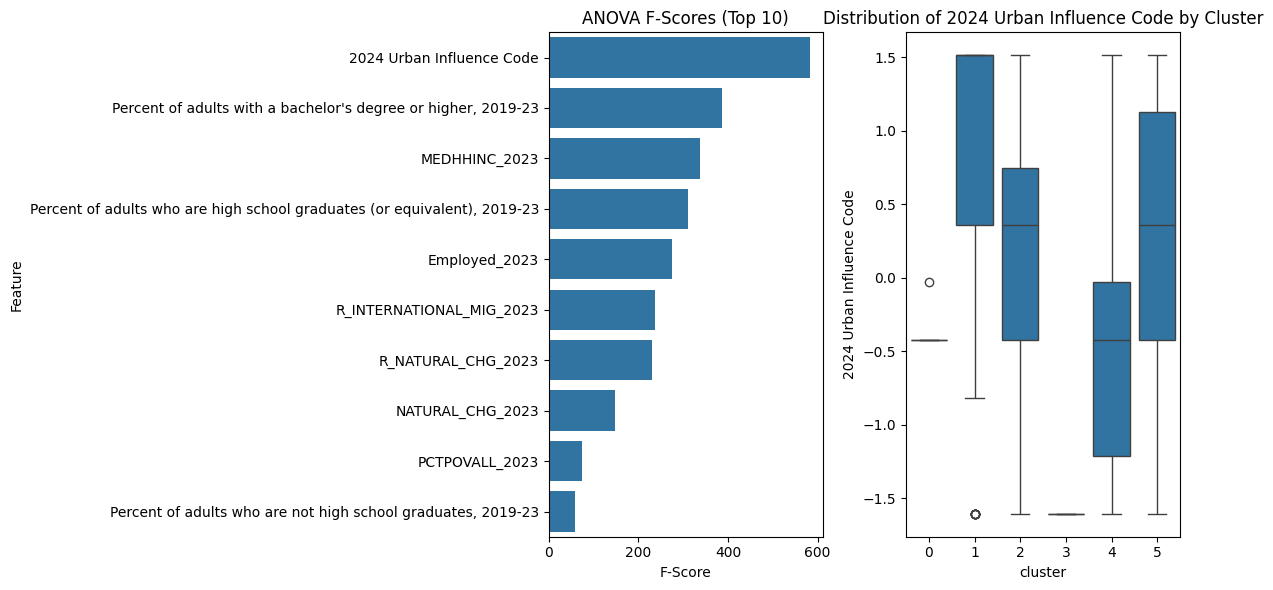

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 6))

# Plot feature importance
plt.subplot(1, 2, 1)
sns.barplot(data=feature_importance.head(10), x='F-Score', y='Feature')
plt.title("ANOVA F-Scores (Top 10)")

# Plot cluster means for top features
top_feature = feature_importance.iloc[0]['Feature']
plt.subplot(1, 2, 2)
sns.boxplot(data=df, x='cluster', y=top_feature)
plt.title(f"Distribution of {top_feature} by Cluster")

plt.tight_layout()
plt.show()

In [ ]:
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score
import numpy as np

# Parameter grid
param_grid = {
    'n_components': range(4, 10),
    'covariance_type': ['full', 'tied', 'diag', 'spherical'],
    'init_params': ['kmeans', 'random']
}

# Evaluation function
def evaluate_gmm(X, n_components, covariance_type, init_params):
    model = GaussianMixture(
        n_components=n_components,
        covariance_type=covariance_type,
        init_params=init_params,
        random_state=42
    )
    labels = model.fit_predict(X)
    return silhouette_score(X, labels)

# Grid search
results = []
for n in param_grid['n_components']:
    for cov_type in param_grid['covariance_type']:
        for init in param_grid['init_params']:
            score = evaluate_gmm(X_scaled, n, cov_type, init)
            results.append({
                'n_components': n,
                'covariance_type': cov_type,
                'init_params': init,
                'silhouette': score
            })

# Convert to DataFrame and find best
results_df = pd.DataFrame(results)
best_params = results_df.loc[results_df['silhouette'].idxmax()]
print("Optimal Parameters:\n", best_params)

In [15]:
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from sklearn.preprocessing import StandardScaler

# Prepare data (exclude non-numeric and target columns)
X = df.select_dtypes(include=['number']).drop(columns=['cluster', 'FIPS'], errors='ignore')
X_scaled = StandardScaler().fit_transform(X)

# Calculate evaluation metrics
metrics = {
    "Silhouette Score": silhouette_score(X_scaled, df['cluster']),
    "Calinski-Harabasz Index": calinski_harabasz_score(X_scaled, df['cluster']),
    "Davies-Bouldin Index": davies_bouldin_score(X_scaled, df['cluster'])
}

print("Clustering Evaluation Metrics:")
for name, value in metrics.items():
    print(f"{name}: {value:.3f}")

Clustering Evaluation Metrics:
Silhouette Score: 0.002
Calinski-Harabasz Index: 174.622
Davies-Bouldin Index: 3.878


without normalization

 Clustering Evaluation Metrics:
Silhouette Score: -0.029
Calinski-Harabasz Index: 147.655
Davies-Bouldin Index: 4.009

###

## other viz 

In [14]:
#pca works better? 
pca = PCA(n_components=3, random_state=42)
X_pca_3d = pca.fit_transform(X_scaled)

fig = px.scatter_3d(
    x=X_pca_3d[:, 0], 
    y=X_pca_3d[:, 1], 
    z=X_pca_3d[:, 2],
    color=df['cluster'].astype(str),  
    hover_data={'County': df['Name']},  
    title='3D PCA Clustering'
)

fig.update_traces(marker_size=5)
fig.show()

#### fixing wrong fips -> county mapping ?


In [19]:
# csv from https://erddap.emodnet.eu/erddap/convert/fipscounty.html
# https://github.com/plotly/datasets/blob/master/geojson-counties-fips.json out of date 

# here https://eric.clst.org/tech/usgeojson/
# shp file from https://www.census.gov/geographies/mapping-files/time-series/geo/cartographic-boundary.html

In [ ]:
df[df['FIPS']=="30105"]

In [30]:
import geopandas as gpd


gdf = gpd.read_file('data/counties_2023.geojson')
gdf = gdf.to_crs('EPSG:4326')
plotly_geojson = json.loads(gdf.set_index('GEOID').to_json())

In [ ]:
df["FIPS"] = df["FIPS"].astype(str).str.zfill(5) # https://github.com/plotly/datasets/issues/29

df['cluster'] = df['cluster'].astype(str)
df = df.sort_values(by='cluster')

fig = px.choropleth(
    df,
    geojson=plotly_geojson,
    locations='FIPS',  
    color='cluster',     
    color_discrete_sequence=px.colors.qualitative.Plotly,  
    scope="usa",
    hover_name='Name',  
    title='US County Clusters'
)

fig.update_geos(
    visible=False,
    bgcolor='rgba(0,0,0,0)'
)

fig.update_traces(
    marker_line_width=0.1,
    marker_opacity=0.8,
    hovertemplate="<b>%{customdata[0]}</b><br>" +  # Display the county name
                  "FIPS: %{location}<br>" +
                  "Cluster: %{customdata[1]}<extra></extra>",  
    customdata=df[['Name', 'cluster']].values
)


fig.update_layout(
    height=600,
    width=1000,
    margin={"r":0,"t":40,"l":0,"b":0},
    legend_title_text='Cluster'
)

fig.show()